In [1]:
import pandas as pd
from Bio import PDB
import numpy as np
parser=PDB.PDBParser()

from rdkit import Chem
info=pd.read_csv("final_info.csv",index_col=0)

In [2]:
info

,header,smiles,category,seq,resolution,date,type,new_split,CL1,CL2,CL3,remove_for_balancing_val,kd/ki,value
6r8o,isomerase,CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)...,refined,GNPLVYLDVDANGKPLGRVVLELKADVVPKTAENFRALCTGEKGFG...,1.36,2019-11-27,isomerase,test,True,True,True,False,Kd=0.006uM,8.22
3fh7,hydrolase/hydrolase inhibitor,O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...,refined,VDTCSLASPASVCRTKHLHLRCSVDFTRRTLTGTAALTVQSQEDNL...,2.05,2010-01-05,hydrolase,test,True,True,True,False,Kd=25nM,7.60
4b7r,hydrolase,CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])...,refined,VKLAGNSSLCPVSGWAIYSKDNSVRIGSKGDVFVIREPFISCSPLE...,1.90,2012-10-03,hydrolase,NaN,True,True,True,False,Ki=0.23nM,9.64
3qfd,immune system,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@...,refined,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,1.68,2011-09-28,other,train,False,False,False,False,Kd=68uM,4.17
3fvn,membrane protein,[NH3+][C@@H](C[C@]1(C(=O)[O-])C[C@H]2OCC[C@@H]...,refined,ANRTLIVTTILEEPYVMYRKSDKPLYGNDRFEGYCLDLLKELSNIL...,1.50,2010-01-19,membrane,val,True,True,True,False,Ki=169nM,6.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6npt,transferase,CC(C)(C)c1ccc(C(=O)Nc2cc(-c3ccccc3)nn2-c2ccccc...,general,IENCVHHIKRRDIVLKWELGEGAFGKVFLAECHNLLPEQDKMLVAV...,2.19,2019-05-22,transferase,test,True,False,False,False,IC50=68.3nM,7.17
3pax,transferase,COc1cccc(C(N)=O)c1,general,KSKLAKPIQDLIKMIFDVESMKKAMVEFEIDLQKMPLGKLSKRQIQ...,2.40,1998-05-27,transferase,val,True,False,False,False,IC50=10uM,5.00
5ezz,hydrolase/inhibitor,Cc1cc([C@@]2(c3cccc(-c4cncc(Cl)c4)c3)COC(=[NH2...,general,RGSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVG...,2.10,2016-02-24,hydrolase,test,True,False,False,False,IC50=145nM,6.84
1hgi,viral protein,CO[C@]1(C(=O)[O-])C[C@H](OC(C)=O)[C@@H](NC(C)=...,general,QDLPGNDNSTATLCLGHHAVPNGTLVKTITDDQIEVTNATELVQSS...,2.70,1994-01-31,viral,train,True,True,False,False,Kd=2.1mM,2.68


In [3]:
from scipy.spatial.distance import cdist
from Bio import PDB
from rdkit.Chem import Descriptors
parser=PDB.PDBParser(QUIET=True)

def get_minimum_dist(pdbid, folder="v2020-other-PL"):
    pocket=parser.get_structure(pdbid,f"{folder}/{pdbid}/{pdbid}_pocket.pdb")[0]
    needed_residues=[res for res in pocket.get_residues() if res.get_resname() != "HOH"]
    needed_atoms_with_H=[atom for res in needed_residues for atom in res.get_atoms() ]
    needed_atoms_no_H=[atom for atom in needed_atoms_with_H if atom.element != "H"]
    pocket_coords_with_H=np.array([atom.get_coord() for atom in needed_atoms_with_H])
    pocket_coords_no_H=np.array([atom.get_coord() for atom in needed_atoms_no_H])
    pocket_elements_with_H=[atom.element for atom in needed_atoms_with_H]
    pocket_elements_no_H=[atom.element for atom in needed_atoms_no_H]

    try:
        ligand=Chem.MolFromMol2File(f"{folder}/{pdbid}/{pdbid}_ligand.mol2", removeHs=False)

    except:
        try:
            ligand=Chem.SDMolSupplier(f"{folder}/{pdbid}/{pdbid}_ligand.sdf",sanitize=False)
        except:
            ligand=None

    if ligand is not None:
        ligand_coords_with_H=ligand.GetConformer().GetPositions()
        ligand_elements_with_H=[atom.GetSymbol() for atom in ligand.GetAtoms()]

        ligand_no_H=Chem.RemoveHs(ligand)
        ligand_coords_no_H=ligand_no_H.GetConformer().GetPositions()
        ligand_elements_no_H=[atom.GetSymbol() for atom in ligand_no_H.GetAtoms()]
    else:
        return None
    
    distances_all_no_H=cdist(pocket_coords_no_H,ligand_coords_no_H)
    min_dist_no_H=distances_all_no_H.min()
    index_x,index_y=np.unravel_index(distances_all_no_H.argmin(), distances_all_no_H.shape)
    min_dist_pocket_element=pocket_elements_no_H[index_x]
    min_dist_ligand_element=ligand_elements_no_H[index_y]

    distances_pocket_no_H_ligand_with_H=cdist(pocket_coords_no_H,ligand_coords_with_H)
    min_dist_pocket_no_H_ligand_with_H=distances_pocket_no_H_ligand_with_H.min()
    index_x,index_y=np.unravel_index(distances_pocket_no_H_ligand_with_H.argmin(), distances_pocket_no_H_ligand_with_H.shape)
    min_dist_pocket_no_H_ligand_with_H_pocket_element=pocket_elements_no_H[index_x]
    min_dist_pocket_no_H_ligand_with_H_ligand_element=ligand_elements_with_H[index_y]

    distances_pocket_with_H_ligand_no_H=cdist(pocket_coords_with_H,ligand_coords_no_H)
    min_dist_pocket_with_H_ligand_no_H=distances_pocket_with_H_ligand_no_H.min()
    index_x,index_y=np.unravel_index(distances_pocket_with_H_ligand_no_H.argmin(), distances_pocket_with_H_ligand_no_H.shape)
    min_dist_pocket_with_H_ligand_no_H_pocket_element=pocket_elements_with_H[index_x]
    min_dist_pocket_with_H_ligand_no_H_ligand_element=ligand_elements_no_H[index_y]

    return ((min_dist_no_H,min_dist_pocket_element,min_dist_ligand_element),
            (min_dist_pocket_no_H_ligand_with_H,min_dist_pocket_no_H_ligand_with_H_pocket_element,min_dist_pocket_no_H_ligand_with_H_ligand_element),
            (min_dist_pocket_with_H_ligand_no_H,min_dist_pocket_with_H_ligand_no_H_pocket_element,min_dist_pocket_with_H_ligand_no_H_ligand_element))
    


def get_pocket_stats(pdbid, folder="v2020-other-PL", remove_Hs=False):
    pocket=parser.get_structure(pdbid,f"{folder}/{pdbid}/{pdbid}_pocket.pdb")[0]
    needed_residues=[res for res in pocket.get_residues() if res.get_resname() != "HOH"]
    needed_atoms=[atom for res in needed_residues for atom in res.get_atoms() ]
    if remove_Hs:
        needed_atoms=[atom for atom in needed_atoms if atom.element != "H"]
    pocket_coords=np.array([atom.get_coord() for atom in needed_atoms])
    pocket_elements=set([atom.element for atom in needed_atoms])
    # pocket=Chem.MolFromPDBFile(f"{folder}/{pdbid}/{pdbid}_pocket.pdb",sanitize=False, removeHs=remove_Hs)
    # if remove_Hs:
    #     try:
    #         pocket=Chem.RemoveHs(pocket)
    #     except:
    #         return None
    # pocket_coords=pocket.GetConformer().GetPositions()
    # pocket_elements=set([atom.GetSymbol() for atom in pocket.GetAtoms()])
    try:
        ligand=Chem.MolFromMol2File(f"{folder}/{pdbid}/{pdbid}_ligand.mol2", removeHs=remove_Hs)

    except:
        try:
            ligand=Chem.SDMolSupplier(f"{folder}/{pdbid}/{pdbid}_ligand.sdf",sanitize=False, removeHs=remove_Hs)
        except:
            ligand=None

    if ligand is not None:
        ligand_coords=ligand.GetConformer().GetPositions()
        ligand_elements=set([atom.GetSymbol() for atom in ligand.GetAtoms()])
    else:
        return None
    
    distances=cdist(pocket_coords,ligand_coords)
    min_dist=distances.min()
    return min_dist,pocket_elements,ligand_elements

get_pocket_stats("3n9s","refined-set", remove_Hs=True)


(1.915857469465719, {'C', 'N', 'O', 'S', 'ZN'}, {'C', 'N', 'O', 'P'})

In [4]:
get_minimum_dist("3n9s","refined-set")

((1.915857469465719, 'ZN', 'O'),
 (1.915857469465719, 'ZN', 'O'),
 (1.6252777684776907, 'H', 'O'))

In [75]:
folder="v2020-other-PL"
pdbid="6gjy"
remove_Hs=True
pocket=parser.get_structure(pdbid,f"{folder}/{pdbid}/{pdbid}_pocket.pdb")[0]
needed_residues=[res for res in pocket.get_residues() if res.get_resname() != "HOH"]
needed_atoms=[atom for res in needed_residues for atom in res.get_atoms() ]

/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 442
  warnings.warn(


In [88]:
from tqdm import tqdm
from rdkit.Chem import Descriptors

min_dist_record=[]
processed_pdbids=[]
counter=0
prot_element_counter={}
lig_element_counter={}

for selected_index in tqdm(info.index):
    category=info.loc[selected_index,"category"]
    if category == "general":
        folder="v2020-other-PL"
    elif category == "refined":
        folder="refined-set"
    elif category == "core":
        folder="CASF-2016/coreset"
    pdb_stats=get_pocket_stats(selected_index,folder,remove_Hs=True)
    if pdb_stats is None:
        continue
    counter+=1
    processed_pdbids.append(selected_index)
    min_dist,qed,pocket_elements,ligand_elements=pdb_stats
    min_dist_record.append(min_dist)
    for element in pocket_elements:
        if element not in prot_element_counter:
            prot_element_counter[element]=1
        else:
            prot_element_counter[element]+=1
    for element in ligand_elements:
        if element not in lig_element_counter:
            lig_element_counter[element]=1
        else:
            lig_element_counter[element]+=1

min_dist_record=np.array(min_dist_record)

 33%|███▎      | 6463/19443 [00:42<01:18, 164.78it/s][12:44:54] 6rsa_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:44:54] Unusual charge on atom 20 number of radical electrons set to zero
 46%|████▌     | 8898/19443 [00:58<01:12, 145.75it/s][12:45:09] sanitise [12:45:09] 4rlp_ligand: [12:45:10] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[12:45:10] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[12:45:10] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[12:45:10] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
 49%|████▉     | 9551/19443 [01:03<01:04, 152.72it/s][12:45:11] sanitise [12:45:11] 3lp2_ligand: [12:45:15] 6db4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[12:45:15] WARNING: could not find number of exp

## CL1

In [167]:
# create CL1 definitions
CL1={}
for selected_index in tqdm(info.index):
    category=info.loc[selected_index,"category"]
    if category == "general":
        folder="v2020-other-PL"
    elif category == "refined":
        folder="refined-set"
    elif category == "core":
        folder="CASF-2016/coreset"
    pdb_stats=get_pocket_stats(selected_index,folder,remove_Hs=True)
    if pdb_stats is None:
        CL1[selected_index]=False
        continue
    
    min_dist,pocket_elements,ligand_elements=pdb_stats
    if type(info.loc[selected_index,"smiles"]) != str:
        CL1[selected_index]=False
        continue
    try:
        qed=Descriptors.qed(Chem.MolFromSmiles(info.loc[selected_index,"smiles"]))
    except:
        qed=0
    if min_dist < 1.75:   # criterion 1
        CL1[selected_index]=False
        continue

    if qed < 0.2:   # criterion 2
        CL1[selected_index]=False
        continue

    if np.any([element.upper() not in ["C","S","O","N","ZN","CA","CO","MG","NI","MN","FE","NA","K","SE","P","CD"] 
               for element in pocket_elements]):
        CL1[selected_index]=False
        continue

    if np.any([element.upper() not in ["C","S","O","N","CL", "P", "F", "BR", "I", "B"] 
               for element in ligand_elements]):
        CL1[selected_index]=False
        continue

    CL1[selected_index]=True


 30%|███       | 5840/19443 [00:45<01:39, 136.88it/s][15:29:30] Unusual charge on atom 13 number of radical electrons set to zero
[15:29:30] Unusual charge on atom 1 number of radical electrons set to zero
[15:29:30] Unusual charge on atom 1 number of radical electrons set to zero
 30%|███       | 5869/19443 [00:45<01:38, 137.85it/s][15:29:30] Unusual charge on atom 30 number of radical electrons set to zero
[15:29:30] Unusual charge on atom 2 number of radical electrons set to zero
[15:29:30] Unusual charge on atom 2 number of radical electrons set to zero
 31%|███▏      | 6114/19443 [00:47<01:37, 137.04it/s][15:29:30] sanitise [15:29:30] 5HLM_LIGAND: [15:29:32] Unusual charge on atom 41 number of radical electrons set to zero
[15:29:32] Unusual charge on atom 36 number of radical electrons set to zero
[15:29:32] Unusual charge on atom 36 number of radical electrons set to zero
 33%|███▎      | 6464/19443 [00:50<01:32, 139.58it/s][15:29:35] 6rsa_ligand: Warning - no explicit hydrogens

In [174]:
info["OLD_CL1"]=info["CL1"]
CL1=pd.Series.from_dict(CL1,orient="index")
info["CL1"]=CL1

## CL2

In [176]:
# recognize Kd=/Ki= cases from general
general_index=pd.read_fwf("/home/jerry/data/pdbbind/index/INDEX_general_PL_data.2020",
                     skiprows=6,
                     header=None,
                     colspecs=[[0,4],[4,10],[10,16],[16,23],[23,39]])
general_index.columns = ["pdbid", "resolution", "year", "value", "kd/ki"]
general_index.index=general_index.pdbid

refined_index=pd.read_fwf("/home/jerry/data/pdbbind/index/INDEX_refined_data.2020", \
                        skiprows=6,
                     header=None,
                     colspecs=[[0,4],[4,10],[10,16],[16,23],[23,39]])
refined_index.columns = ["pdbid", "resolution", "year", "value", "kd/ki"]
refined_index.index=refined_index.pdbid

In [180]:
info=info.join(general_index[["kd/ki","value"]])

In [184]:
CL2=general_index["kd/ki"].str.startswith("Kd=")|general_index["kd/ki"].str.startswith("Ki=")

In [188]:
CL2=general_index["kd/ki"].str.startswith("Kd=")|general_index["kd/ki"].str.startswith("Ki=")
CL2=CL1[0]&CL2

In [191]:
info["CL2"]=CL2

## CL3

In [192]:
info["CL3"]=info["CL1"]&((info["category"]!="general"))

In [193]:
len(info), info["CL1"].sum(), info["CL2"].sum(), info["CL3"].sum()

(19443, 14324, 7985, 4404)

In [200]:
info.drop(columns=["new_CL1","OLD_CL1"]).to_csv("final_info.csv")

# Statistics

In [210]:

type_order=["hydrolase",   
"transferase"  ,
"other" ,
"transcription",
"lyase"        ,
"transport"    ,
"oxidoreductase",
"ligase"       ,
"isomerase"    ,
"chaperone"    ,
"membrane"     ,
"viral"        ,
"metal_containing",
]
summary=info[info.CL3].pivot_table(index="type", columns="new_split", values="seq", aggfunc="count").sort_index(key=lambda x: [type_order.index(y) for y in x])[["train","val","test"]]

In [211]:
summary

new_split,train,val,test
type,,,
hydrolase,873.0,56.0,411.0
transferase,355.0,237.0,257.0
other,542.0,91.0,58.0
transcription,122.0,15.0,70.0
lyase,85.0,39.0,308.0
transport,114.0,20.0,26.0
oxidoreductase,64.0,6.0,29.0
ligase,37.0,6.0,31.0
isomerase,41.0,18.0,21.0


In [212]:
summary.sum(axis=0)

new_split
train    2280.0
val       557.0
test     1348.0
dtype: float64

In [197]:
info.columns

Index(['header', 'smiles', 'category', 'seq', 'resolution', 'date', 'type',
       'new_split', 'CL1', 'CL2', 'CL3', 'remove_for_balancing_val', 'new_CL1',
       'OLD_CL1', 'kd/ki', 'value'],
      dtype='object')

## Ligand prop dists

In [3]:
from rdkit import Chem
from tqdm import tqdm

mols=[]
valid_smi=[]
for smi in tqdm(info.smiles):
    try:
        mols.append(Chem.MolFromSmiles(smi))
        valid_smi.append(True)
    except:
        mols.append(None)
        valid_smi.append(False)

from rdkit.Chem import QED, Lipinski
import numpy as np

nhas=[Lipinski.HeavyAtomCount(mol) if mol is not None else np.nan for mol in mols]
mws=[QED.properties(mol).MW if mol is not None else np.nan for mol in mols]
qeds=[QED.qed(mol) if mol is not None else np.nan for mol in mols]

nhas_series=pd.Series(nhas,index=info.index)
mws_series=pd.Series(mws,index=info.index)
qeds_series=pd.Series(qeds,index=info.index)

 28%|██▊       | 5440/19443 [00:00<00:01, 7769.51it/s][14:50:16] Explicit valence for atom # 34 N, 4, is greater than permitted
[14:50:16] Unusual charge on atom 1 number of radical electrons set to zero
[14:50:16] Unusual charge on atom 2 number of radical electrons set to zero
[14:50:16] Unusual charge on atom 36 number of radical electrons set to zero
 36%|███▌      | 6931/19443 [00:01<00:02, 5826.65it/s][14:50:16] Unusual charge on atom 16 number of radical electrons set to zero
[14:50:16] Explicit valence for atom # 3 N, 4, is greater than permitted
 42%|████▏     | 8161/19443 [00:01<00:01, 5669.49it/s][14:50:16] Unusual charge on atom 17 number of radical electrons set to zero
[14:50:16] Unusual charge on atom 16 number of radical electrons set to zero
 73%|███████▎  | 14214/19443 [00:02<00:00, 5998.96it/s][14:50:17] Unusual charge on atom 18 number of radical electrons set to zero
[14:50:17] Unusual charge on atom 18 number of radical electrons set to zero
100%|██████████| 19443

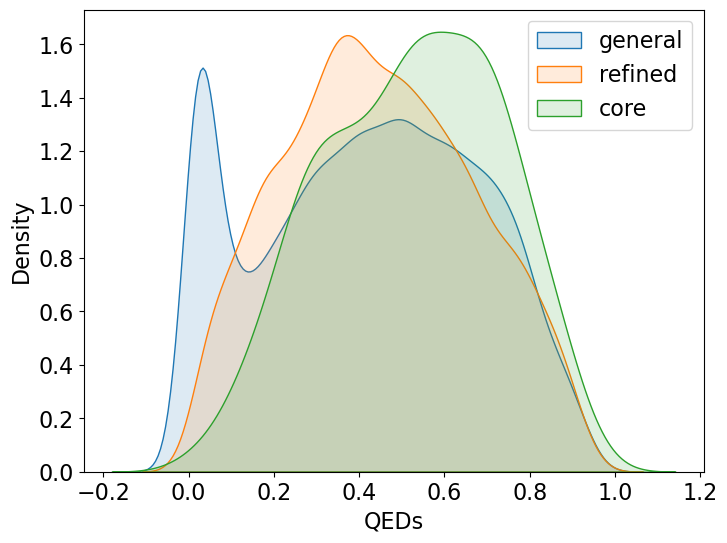

In [10]:
import seaborn
import matplotlib.pyplot as plt

# change figure font size
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,6))
for category in ["general", "refined", "core"]:
    seaborn.kdeplot(qeds_series[info.category==category], label=category, fill=True, alpha=0.15)
plt.legend()
plt.xlabel("QEDs")

plt.savefig("figures/pdbbind_qeds.png", dpi=300, bbox_inches="tight")


## Ligand structures viz

In [12]:
i=0
selected=[]
while i<12:
    random_sampled_idx=np.random.choice(info.index)
    idx_pos=info.index.get_loc(random_sampled_idx)
    if valid_smi[idx_pos]:
        print(random_sampled_idx,idx_pos)
        selected.append(mols[idx_pos])
        i+=1

4rxh 14822
4prh 17164
4p4i 6420
3ow4 15051
3tiy 12397
5db0 12067
1nhu 1720
1tkx 10359
4nkt 2603
2ygf 4972
6h76 11587
6qgg 4508


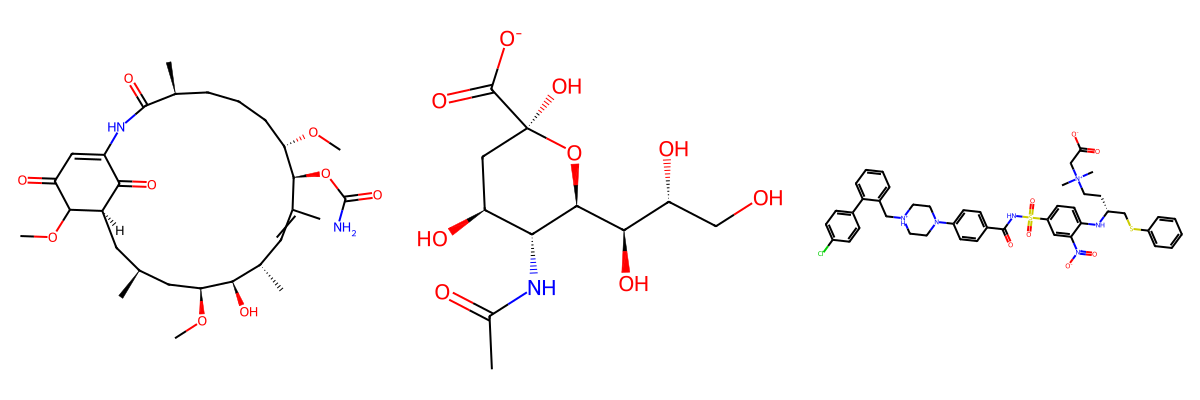

In [17]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

Draw.MolsToImage(selected[9:], subImgSize=(400,400))

In [166]:
Chem.MolFromSmiles(info.loc[selected_index,"smiles"])

[15:28:19] Explicit valence for atom # 34 N, 4, is greater than permitted


In [168]:
pd.DataFrame.from_dict(CL1,orient="index").sum()

0    14324
dtype: int64

In [173]:
info.CL1.sum()

14850

In [169]:
info["new_CL1"]=pd.DataFrame.from_dict(CL1,orient="index")

In [172]:
info[(info.CL1==False)&(info.new_CL1)].type.value_counts()

metal_containing    71
Name: type, dtype: int64

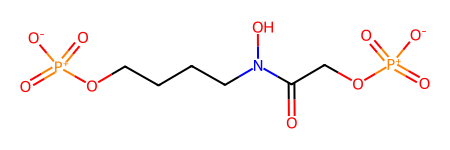

In [158]:
Chem.MolFromSmiles("O=C(CO[P+](=O)(=O)[O-])N(O)CCCCO[P+](=O)(=O)[O-]")

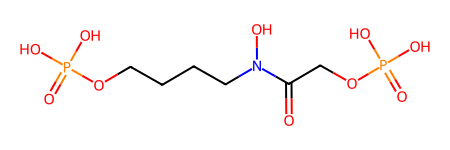

In [159]:
Chem.MolFromSmiles("O=C(COP(=O)(O)O)N(O)CCCCOP(=O)(O)O")

In [148]:

Descriptors.qed(Chem.MolFromSmiles("O=C(COP(=O)(O)O)N(O)CCCCOP(=O)(O)O"))

0.15629754359615364

In [66]:
min_dist_record.argmin()

11679

In [90]:
min_distances=pd.DataFrame({"pdbid":processed_pdbids,"min_dist":min_dist_record})
min_distances.index=min_distances["pdbid"]
min_distances=min_distances.join(info[["category","CL1"]])

In [125]:
a=min_distances[min_distances.min_dist<1.6]
x=a[a.CL1].sort_values("min_dist")
x

,pdbid,min_dist,category,CL1
pdbid,,,,
2z97,2z97,0.502772,general,True
4gs9,4gs9,0.571924,general,True
6euv,6euv,0.662215,general,True
6rrm,6rrm,0.684803,general,True
4oel,4oel,0.735322,general,True
...,...,...,...,...
2wzx,2wzx,1.594847,general,True
1ew8,1ew8,1.595127,refined,True
4q2k,4q2k,1.597097,general,True


In [124]:
x.loc[["4bxn","4r18","6euv","2xow","4gs9","3fck","3uo9"]]

,pdbid,min_dist,category,CL1
pdbid,,,,
4bxn,4bxn,1.348058,general,True
4r18,4r18,1.330678,general,True
6euv,6euv,0.662215,general,True
2xow,2xow,1.407761,general,True
4gs9,4gs9,0.571924,general,True
3fck,3fck,1.297876,general,True
3uo9,3uo9,1.041654,general,True


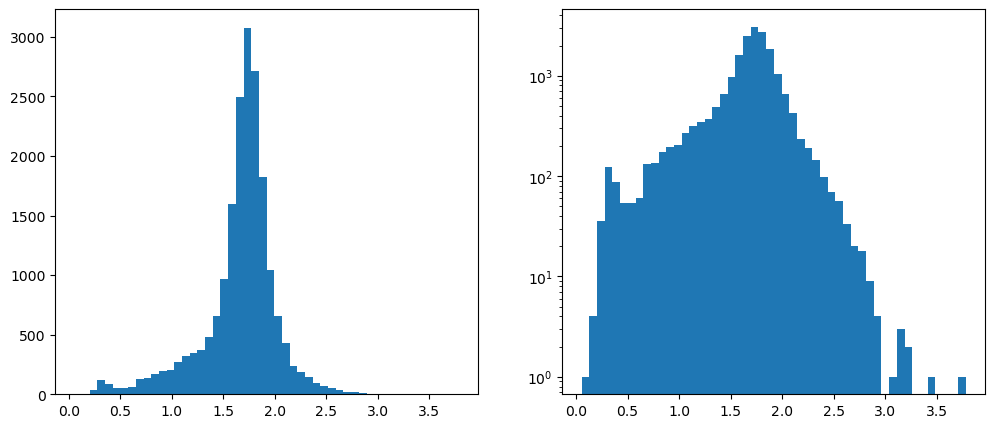

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(min_dist_record[min_dist_record<10],bins=50);
plt.subplot(1,2,2)
plt.hist(min_dist_record[min_dist_record<10],bins=50,log=True);

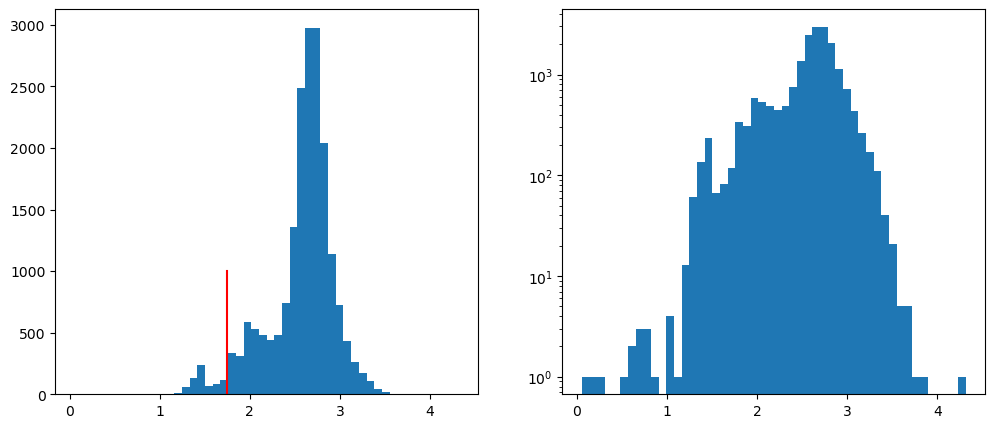

In [108]:
criterion=1.75

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(min_dist_record[min_dist_record<10],bins=50);
plt.plot([criterion,criterion],[0,1000],color="red")
plt.subplot(1,2,2)
plt.hist(min_dist_record[min_dist_record<10],bins=50,log=True);

In [128]:
counter

19398

In [134]:
for elem in prot_element_counter:
    print(elem,prot_element_counter[elem],"%.2f"%(prot_element_counter[elem]/counter))

C 19398 1.00
S 16375 0.84
O 19398 1.00
N 19398 1.00
ZN 1842 0.09
CA 400 0.02
CO 66 0.00
MG 858 0.04
NI 79 0.00
MN 356 0.02
FE 104 0.01
NA 138 0.01
K 78 0.00
SE 107 0.01
HG 6 0.00
CU 16 0.00
CS 1 0.00
P 105 0.01
CD 22 0.00
SR 1 0.00
GA 1 0.00
RB 1 0.00


In [135]:
for elem in lig_element_counter:
    print(elem,lig_element_counter[elem],"%.2f"%(lig_element_counter[elem]/counter))

C 19389 1.00
S 5146 0.27
O 18338 0.95
N 17515 0.90
Cl 2255 0.12
P 2087 0.11
F 2500 0.13
Br 459 0.02
I 133 0.01
B 240 0.01
Se 16 0.00
Fe 21 0.00
Co 4 0.00
V 2 0.00
Ru 10 0.00
Be 1 0.00
Ir 5 0.00
Zn 1 0.00
Mg 1 0.00
Re 1 0.00
As 4 0.00
H 6 0.00
Cu 1 0.00
Pt 2 0.00
Rh 1 0.00
Si 5 0.00
Sb 1 0.00


In [48]:
mol=Chem.MolFromPDBFile("refined-set/3syr/3syr_pocket.pdb", sanitize=False)
mol is None

OSError: Bad input file refined-set/3syr/3syr_pocket.pdb

In [41]:
import os
os.path.exists("v2020-other-PL/1g7v/1g7v_ligand.mol2")

False

In [37]:
selected_index

'1g7v'

In [65]:
info.loc["5swg","category"]

'general'

In [9]:
from rdkit.Chem import Draw

In [16]:
set([atom.GetSymbol() for atom in pocket.GetAtoms()])

{'C', 'N', 'O', 'S'}

# Covalent vs non-covalent binders
according to CovBindersInPDB (https://yzhang.hpc.nyu.edu/CovBinderInPDB/)

In [7]:
import pandas as pd
info=pd.read_csv("final_info_with_covalency.csv",index_col=0)

In [8]:
info.loc["1au0"]

header                                                              hydrolase
smiles                      CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)NCC(O)CNC(=O...
category                                                              general
seq                         APDSVDYRKKGYVTPVKNQGQCGSCWAFSSVGALEGQLKKKTGKLL...
resolution                                                                2.6
date                                                               1998-10-14
type                                                                hydrolase
new_split                                                                test
CL1                                                                      True
CL2                                                                      True
CL3                                                                     False
remove_for_balancing_val                                                False
kd/ki                                                           

In [3]:
cov=pd.read_csv("CovBinderInPDB_2022Q4_AllRecords.csv")[["pdb_id","binder_id_in_adduct"]]

In [4]:
len(set(cov.pdb_id))

3555

In [5]:
cov[cov.pdb_id=="1AU0"]

,pdb_id,binder_id_in_adduct
2854,1AU0,SDK


In [7]:
cov_pdbids=set(cov.pdb_id)

In [8]:
covalent_in_pdbbind=[item for item in info.index if item.upper() in cov_pdbids]

In [9]:
len(covalent_in_pdbbind)

919

In [10]:
false_covalent=["3n3g",
"3kku",
"1hvy",
"4zam",
"1f28",
"4hva",
"4do3",
"4ch8",
"2kce",
"1juj",
"4ch2",
"6avi",
"5mi7",
"6hhp",
"3dla",
"2qnx",
"5mi6",
"1jr1",
"5mi5",
"6hmt",
"4gz3",
"1dva",
"1jtq",
"1jut",
"5vfd",
"2qo1"
]

In [11]:
true_covalent_in_pdbbind=[item.lower() for item in covalent_in_pdbbind if item.lower() not in false_covalent]

In [13]:
len(true_covalent_in_pdbbind)

893

In [15]:
info["covalent"]=False
for item in true_covalent_in_pdbbind:
    info.loc[item,"covalent"]=True

In [17]:
info.covalent.value_counts()

False    18550
True       893
Name: covalent, dtype: int64

/tmp/ipykernel_18545/890591071.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(info[~info.covalent].value,label="non-covalent",alpha=0.5,shade=True)
/tmp/ipykernel_18545/890591071.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(info[info.covalent].value,label="covalent",alpha=0.5,shade=True)


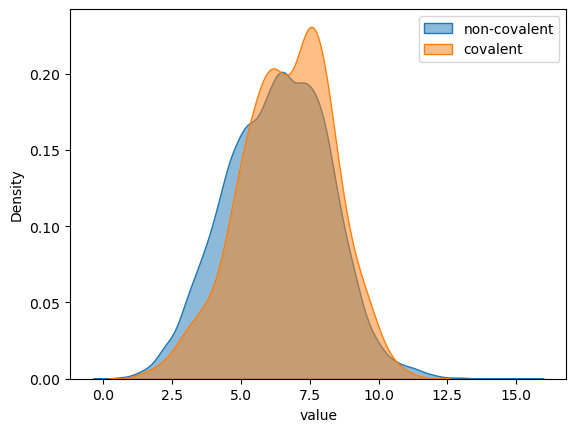

In [31]:
import matplotlib.pyplot as plt
import seaborn

seaborn.kdeplot(info[~info.covalent].value,label="non-covalent",alpha=0.5,shade=True)
seaborn.kdeplot(info[info.covalent].value,label="covalent",alpha=0.5,shade=True)
plt.legend()

In [18]:
info.to_csv("final_info_with_covalency.csv")

In [24]:
from rdkit import Chem
from Bio.PDB import PDBParser
import numpy as np
import os

# three letter codes for all amino acids
excluded_residue_names = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
 'TYR', 'VAL', 'HOH']

parser=PDBParser()

def download_pdb(pdbid, position):
    os.system("wget -O {}/{}.pdb https://files.rcsb.org/view/{}.pdb > /dev/null".format(position, pdbid, pdbid))

def get_pdbid_matched_ligand_name(pdbid, category, tmp_folder="tmp"):
    if category=="general":
        ligand_file = "v2020-other-PL/"+pdbid+"/"+pdbid+"_ligand.mol2"
    elif category in ["refined", "core"]:
        ligand_file = "refined-set/"+pdbid+"/"+pdbid+"_ligand.mol2"
    mol = Chem.MolFromMol2File(ligand_file, sanitize=False)
    mol_center = mol.GetConformer().GetPositions().mean(axis=0)

    # if not os.path.exists(tmp_folder+"/"+pdbid+".pdb"):
    #     download_pdb(pdbid, tmp_folder)
    pdb=parser.get_structure(pdbid, tmp_folder+"/"+pdbid+".pdb")
    resnames = []
    centers = []
    for residue in pdb.get_residues():
        resname = residue.get_resname()
        if resname not in excluded_residue_names:
            resnames.append(resname)
            centers.append(np.mean([atom.get_coord() for atom in residue.get_atoms()], axis=0))

    distances = np.linalg.norm(np.array(centers) - mol_center, axis=1)
    min_dist = distances.min()
    return resnames[np.argmin(distances)], min_dist


In [56]:
item,matched_id

('3sv6', 'SV6')

In [60]:
"SV6" in cov[cov.pdb_id==item.upper()]["binder_id_in_adduct"].values

True

In [32]:
errors = []

for item in covalent_in_pdbbind:
    item_category = info.loc[item,"category"]
    matched_id,min_dist=get_pdbid_matched_ligand_name(item,item_category)
    
    should_be_ligand = list(cov[cov.pdb_id==item.upper()]["binder_id_in_adduct"].unique())
    if (matched_id not in should_be_ligand) or min_dist>1:
        errors.append((item,matched_id,should_be_ligand,min_dist))
    

/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3907.
  warnings.warn(
/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3969.
  warnings.warn(
/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4007.
  warnings.warn(
/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4273.
  warnings.warn(
/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4375.
  warnings.warn(
/home/jerry/anaconda3/envs/PLI/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstr

In [33]:
errors

[('3n3g', '93N', ['935'], 1.2286175778835788),
 ('3kku', 'B95', ['Z22'], 0.1592184858500444),
 ('6q35', 'HD5', ['HD5'], 1.1436597888978708),
 ('5gwz', 'PJE', ['PJE'], 4.44345118016924),
 ('4dkt', 'FIO', ['FIO'], 2.3198067318400946),
 ('4jje', 'B3L', ['1U8'], 1.1932811067262303),
 ('1p06', 'B2F', ['B2F'], 3.602041985888978),
 ('2oc1', 'HU2', ['HU2'], 1.2839868604826083),
 ('1p04', 'B2I', ['B2I'], 4.269481101270985),
 ('5zwh', '9N9', ['9KX'], 0.15583960120665757),
 ('1a3e', 'T16', ['T16'], 27.440258544105454),
 ('5t66', 'C6S', ['C6S'], 1.0166707904833927),
 ('2ql5', 'ASJ', ['ASJ'], 5.909915144391094),
 ('5gwy', 'PJE', ['PJE'], 4.423533036871004),
 ('5oyd', 'BGC', ['NBG'], 1.778060661804438),
 ('5x02', 'F6M', ['F6M'], 1.2436941429478938),
 ('1p10', 'B2V', ['B2V'], 4.51227062787972),
 ('1rhq', '0ZZ', ['0ZZ'], 1.0525053990819735),
 ('2h5d', 'B2V', ['B2V'], 5.6863388624457105),
 ('1f1j', 'ASJ', ['ASJ'], 5.768412856446205),
 ('6m9f', 'IVA', ['TYE'], 4.486911914446581),
 ('3snb', 'ECC', ['ECC'

In [34]:
[item.upper() for item in amino_acids]

['ALA',
 'ARG',
 'ASN',
 'ASP',
 'CYS',
 'GLN',
 'GLU',
 'GLY',
 'HIS',
 'ILE',
 'LEU',
 'LYS',
 'MET',
 'PHE',
 'PRO',
 'SER',
 'THR',
 'TRP',
 'TYR',
 'VAL']

In [32]:
covalent_in_pdbbind

['3n3g',
 '3kku',
 '3hj0',
 '2xlc',
 '6q35',
 '4bcb',
 '5gwz',
 '6p8x',
 '4dkt',
 '3b1t',
 '3bg8',
 '5e0g',
 '1eas',
 '5wej',
 '1z6f',
 '1bio',
 '6b1h',
 '3bjm',
 '5i24',
 '3zcz',
 '4jje',
 '6n4t',
 '4axm',
 '2i72',
 '4qvm',
 '1kdw',
 '3hd3',
 '6hvs',
 '4r3b',
 '1p06',
 '5tg4',
 '5dgj',
 '5dpa',
 '2oc1',
 '1p04',
 '5fao',
 '4qwu',
 '5zwh',
 '4wks',
 '2o7v',
 '4gs6',
 '5c1y',
 '1a3e',
 '4no8',
 '1qx1',
 '2g5t',
 '1ke3',
 '3sn8',
 '4qwl',
 '3zmh',
 '5t66',
 '3kjf',
 '5d9p',
 '5dp5',
 '3d4f',
 '1mxo',
 '1l6y',
 '5wdl',
 '1lhe',
 '1pi4',
 '4bcc',
 '3lj7',
 '1rhm',
 '5wag',
 '6da4',
 '2ql5',
 '6bl1',
 '5om9',
 '6b1j',
 '5gwy',
 '1o45',
 '5oyd',
 '1qwu',
 '4oon',
 '1kds',
 '6cha',
 '6b1f',
 '4qws',
 '6hhh',
 '6bkx',
 '5h6v',
 '3kw9',
 '1ong',
 '4qvl',
 '5x02',
 '5j7s',
 '4an1',
 '5fat',
 '1p10',
 '1rhq',
 '2h5d',
 '6rni',
 '4dcd',
 '6dge',
 '4wkv',
 '4amz',
 '5fa7',
 '6rne',
 '4qz2',
 '1qcp',
 '3p8e',
 '2aux',
 '1i8j',
 '1k2i',
 '2fda',
 '1o4k',
 '3ns7',
 '6b0y',
 '1vsn',
 '5tyn',
 '1au0',
 